In [5]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import pathlib
from os import listdir
from os.path import isfile, join
import pyxdf
import PyQt5
import pickle
#import easygui
from easygui import choicebox

# MNE functions
import mne
from mne import Epochs,find_events

# Custom function
from subfunctions import *

# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

### Load XDF File to Raw instance

In [6]:
## Using EasyGUI

current_path = pathlib.Path().absolute()  

#recording_path = (f"{current_path}\Data")
recording_path = current_path / 'Data'
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f))]

# message to be displayed
text = "Choose Recording File:"
  
# window title
title = "Recording File"
  
# item choices
choices = recording_files
  
# creating a button box
recording_file = choicebox(text, title, choices)

print (f"Recording file: {recording_file}")

## Recording to XDF
current_path = pathlib.Path().absolute()  
data_fname = current_path /'Data'/recording_file
# Add annotation from events
raw,events = read_xdf(fname = data_fname)
raw = add_annot(raw, events)

: 

: 

## Start Pre-Processing

### Defining Filter Paramters

In [4]:

# message to be displayed
text = "Choose Filter Bandwidth:"
 
# window title
title = "P300 Pre-Processing"
 
# list of multiple inputs
input_list = [ "Low-Pass Filter", "High-Pass Filter"]

 
# creating a integer box
[LowPass, HighPass]  = multenterbox(text, title, input_list)


LowPass = float(LowPass)
HighPass = float(HighPass)
print (LowPass, ", ", HighPass)

#filter_method: 
choices = ['fir', 'iir']
# message to be displayed
text = "Choose Filtering Method:"
# window title
title = "P300 Pre-Processing"  
# creating a button box
filter_method = choicebox(text, title, choices)

print (filter_method)

0.5 ,  40.0
iir


In [4]:

selected_filter = BandwidthFilter(LowPass, HighPass, filter_method)

In [5]:
selected_filter

### Filtering

In [6]:
Raw_Filtered = raw.filter(LowPass, HighPass, method=filter_method)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB



### Manual inspect for bad channels

Using matplotlib as 2D backend.


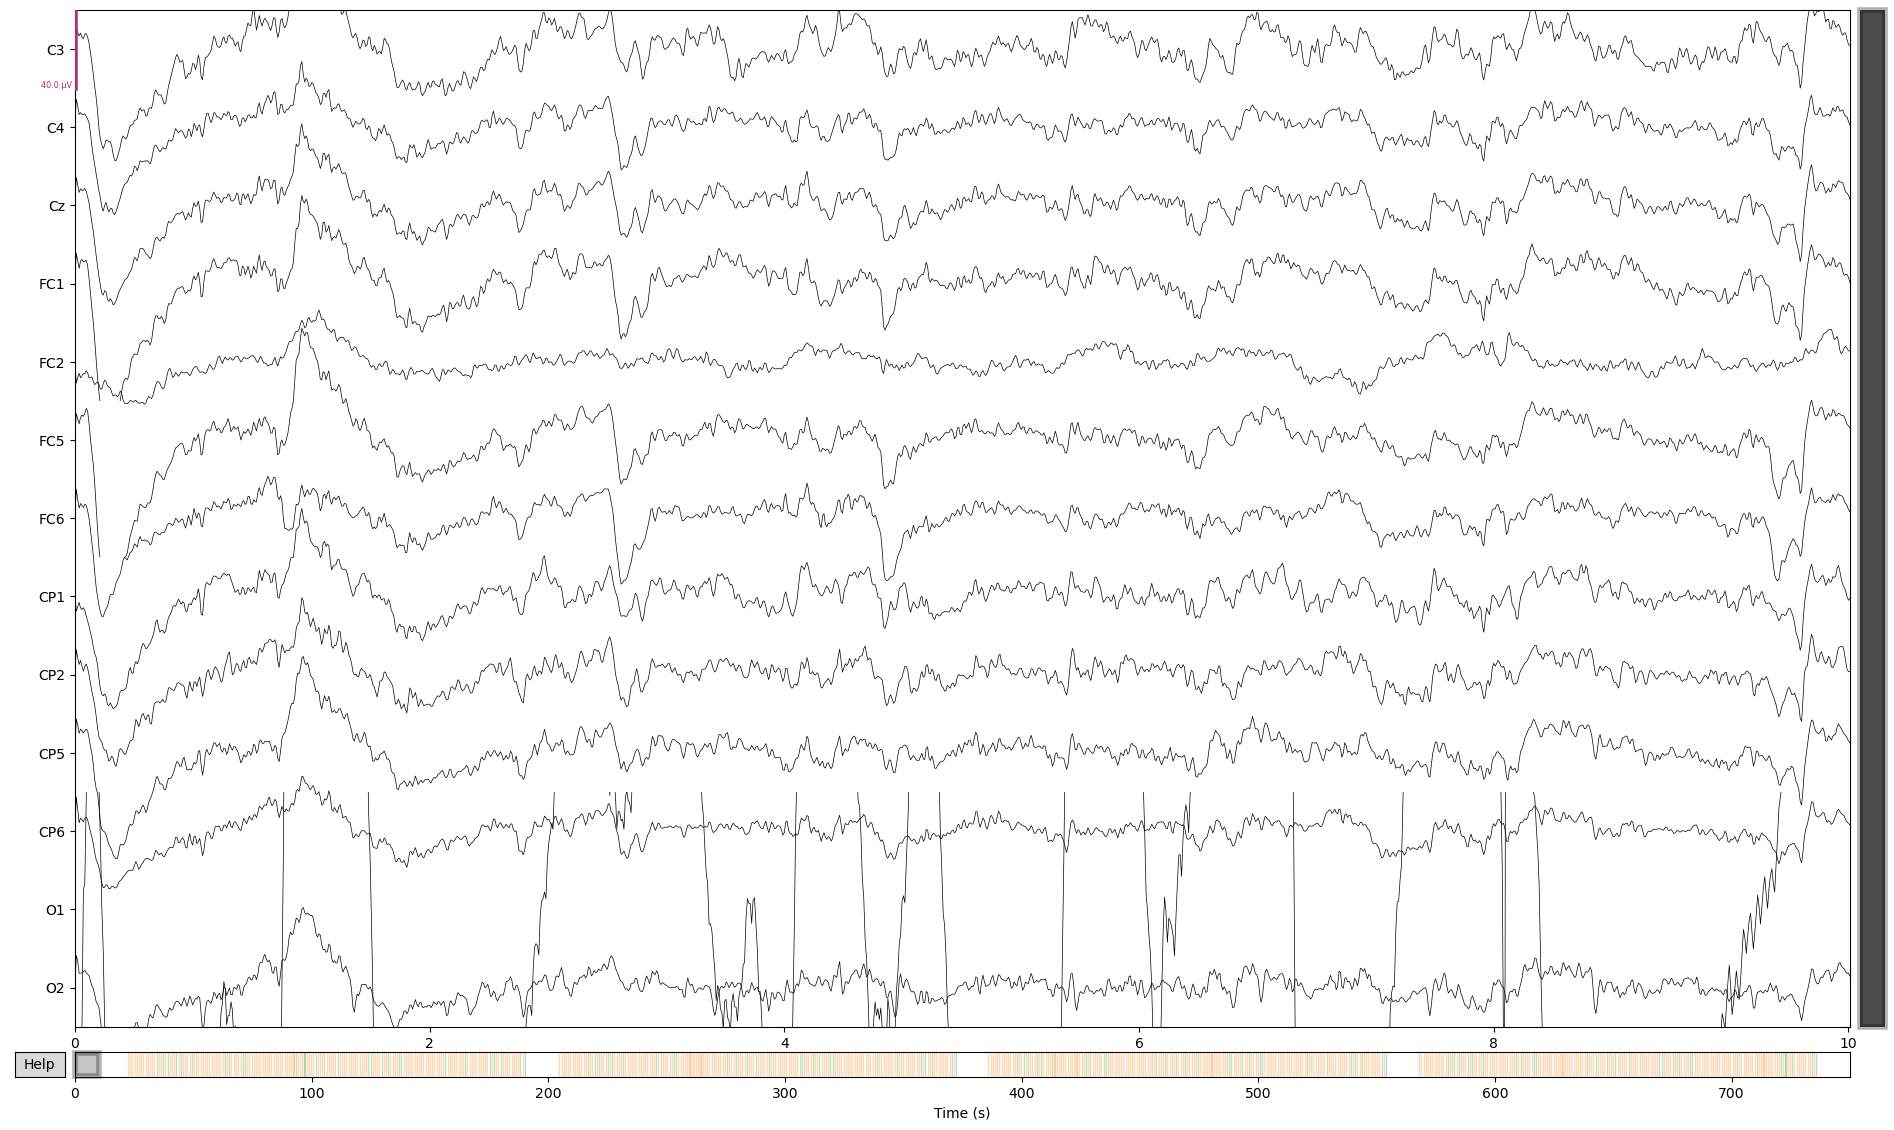

Channels marked as bad:
['O1']


In [13]:
Raw_Filtered.plot()

In [14]:
Bad_Electrodes = Raw_Filtered.info['bads'] 

Raw_Filtered.drop_channels(Raw_Filtered.info['bads'])

<RawArray | 12 x 93750 (750.0 s), ~8.6 MB, data loaded>

## Epoching
### baseline correction by the 200 ms preceding the event 

In [29]:
events_from_annot, event_dict = mne.events_from_annotations(Raw_Filtered)
event_dict.pop('Break')
epochs = mne.Epochs(Raw_Filtered, events_from_annot, tmin=-0.2, tmax=0.5, event_id=event_dict,detrend=None,baseline= (-0.2,0), preload = True)

Used Annotations descriptions: ['Break', 'Standard Trial', 'Target Trial']
Not setting metadata
720 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 720 events and 88 original time points ...
0 bad epochs dropped


### Manual inspect for bad channels
#### Bad channels automatically rejected

In [9]:
plt.plot(epochs[180].get_data()[0,0,:])
plt.show()

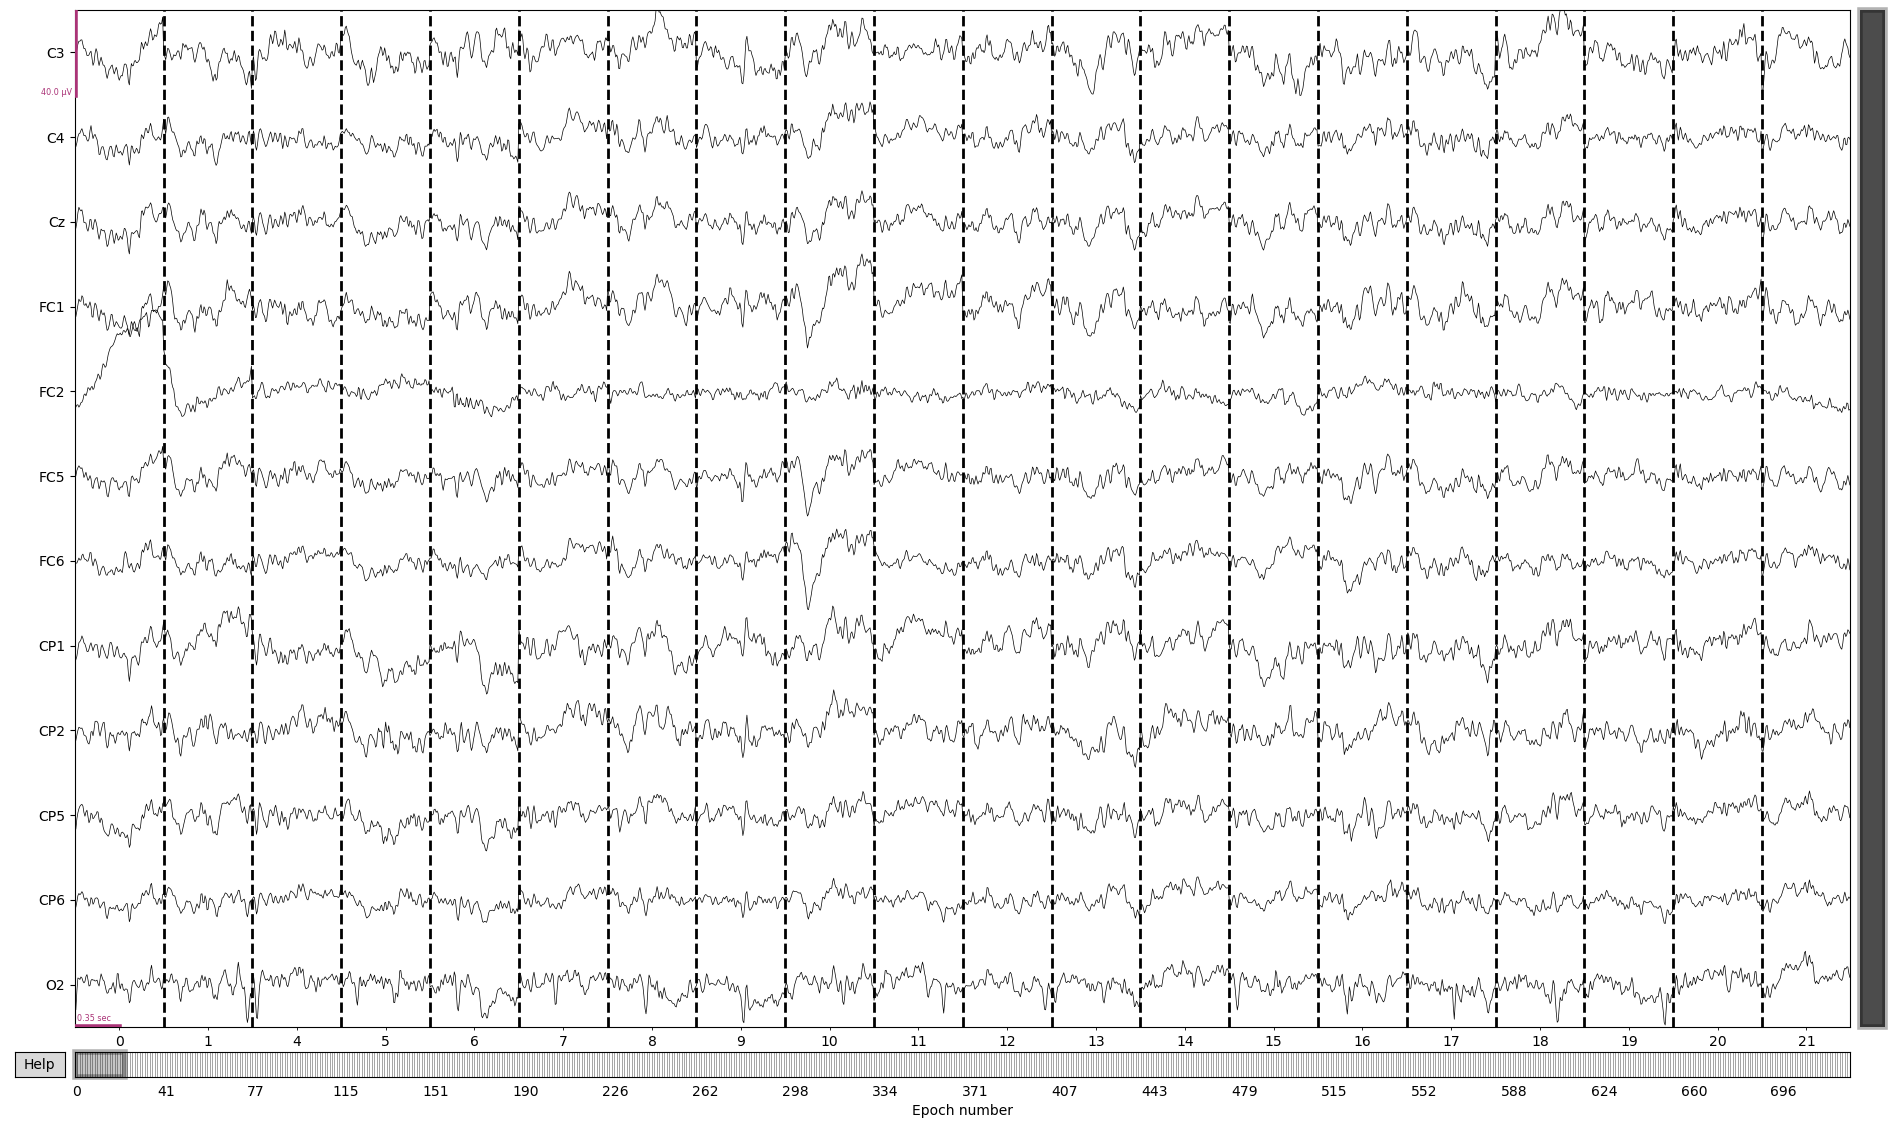

Dropped 24 epochs: 0, 8, 34, 81, 85, 92, 94, 95, 103, 104, 105, 116, 173, 329, 332, 344, 392, 395, 478, 479, 517, 546, 547, 548
The following epochs were marked as bad and are dropped:
[0, 10, 36, 86, 90, 97, 99, 100, 109, 111, 112, 123, 183, 339, 342, 354, 403, 406, 489, 490, 528, 558, 559, 560]
Channels marked as bad:
none


In [24]:
epochs.plot()

In [25]:
epochs

Number of events,687
Events,Standard Trial: 585Target Trial: 102
Time range,-0.200 – 0.496 sec
Baseline,-0.200 – 0.000 sec


## Export the processed epochs file and bandwidth filter

In [27]:
fif_export_path = (f"{current_path}\Data\Processed Data\{recording_file[:-4]}_Processed.fif")
epochs.save(fif_export_path)

bwfilter_export_path = (f"{current_path}\Data\Processed Data\{recording_file[:-4]}_Filter")

with open(bwfilter_export_path, "wb") as file:
    pickle.dump(selected_filter, file)


In [23]:
bwfilter_export_path

'c:\\Users\\gilad\\Cloned_ALS_1304\\BCI_ALS\\Data\\Processed Data\\Or_1304_Filter'

In [22]:
with open(bwfilter_export_path, "rb") as file:
    loaded_object = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\gilad\\Cloned_ALS_1304\\BCI_ALS\\Data\\Processed Data\\Or_1304_Filter'

In [ ]:
ch_names = ['C3','C4','Cz','FC1','FC2','FC5','FC6','CP1','CP2','CP5','CP6','O1','O2']


In [ ]:
epochs.info = mne.create_info(ch_names = ch_names, sfreq=125)